## TD Learning - Taxi Example

This time we will use [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) environment from the [<tt>Gymnasium</tt>](https://gymnasium.farama.org/index.html):

In [1]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using PyCall, Images, Plots

After installing [<tt>gymnasium</tt>](https://github.com/Farama-Foundation/Gymnasium) package we can import it:

In [2]:
gym = pyimport("gymnasium")

PyObject <module 'gymnasium' from 'C:\\Users\\barto\\AppData\\Roaming\\Python\\Python312\\site-packages\\gymnasium\\__init__.py'>

and create an environment:

In [3]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

(331, Dict{Any, Any}("action_mask" => Int8[1, 1, 1, 0, 0, 0], "prob" => 1.0))

In [4]:
mutable struct TaxiEnv <: AbstractEnv
    PyEnv::PyObject
    action_space::UnitRange{Int64}
    state_space::UnitRange{Int64}
    state::Int 
    reward::Union{Nothing, Float64} 
    done::Bool
end
Main.TaxiEnv

TaxiEnv

In [5]:
function TaxiEnv() 
    gym = pyimport("gymnasium")
    env = gym.make("Taxi-v3", render_mode="rgb_array")
    state, _ = env.reset()
    state_space = 0:(py"int($env.observation_space.n)"-1)
    action_space = 0:(py"int($env.action_space.n)"-1)
    return TaxiEnv(env, action_space, state_space, state, nothing, false)
end

TaxiEnv

In [6]:
#functions:
RLBase.action_space(env::TaxiEnv) = env.action_space
RLBase.state_space(env::TaxiEnv) = env.state_space
RLBase.reward(env::TaxiEnv) = env.reward
RLBase.state(env::TaxiEnv, ::Observation, ::DefaultPlayer) = env.state
RLBase.is_terminated(env::TaxiEnv) = env.done
function RLBase.reset!(env::TaxiEnv) 
    env.state, _ = env.PyEnv.reset()
    env.reward = nothing
    env.done = false
    nothing
end

In [7]:
function RLBase.act!(env::TaxiEnv, action)
    @assert action in action_space(env)
    env.state, env.reward, env.done, _, _ = env.PyEnv.step(action)
    nothing
end

In [8]:
function render(env::TaxiEnv)
    img = reinterpretc(RGB{N0f8}, PermutedDimsArray(env.PyEnv.render(), (3, 1, 2)));
    display(img) 
end

render (generic function with 1 method)

In [9]:
env = TaxiEnv()

# TaxiEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |
| EpisodeStyle      |             Episodic() |

## Is Environment Terminated?

No

## State Space

`0:499`

## Action Space

`0:5`

## Current State

```
222
```


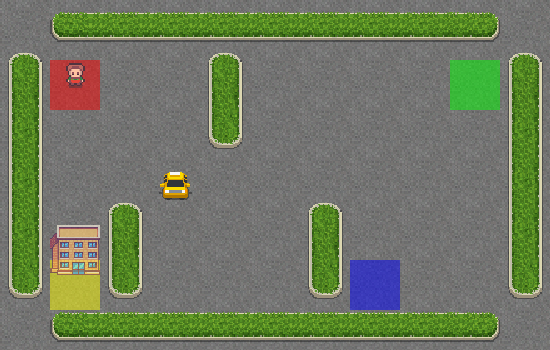

nothing

In [10]:
for i = 1:100
    IJulia.clear_output(true)
    act!(env, rand(action_space(env)))
    render(env) |> IJulia.display
end

Now, we will define agent:

In [11]:
mutable struct Agent
    env::AbstractEnv
    algo::Symbol
    ϵ::Float64 #współczynnik eksploracji
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64 #dyskonto
    α::Float64 #stopa uczenia się
    Q::Dict
    steps_per_episode::Vector{Float64} #ile trwal kazdy z epizodow
    rewards_per_episode::Vector{Float64} #nagroda w kazdym z epizodow
end

function Agent(algo; ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005,
        β = 0.99, α = 0.1) 
    if algo != :SARSA && algo != :Qlearning
        @error "unknown algorithm"
    end
    Agent(TaxiEnv(), algo,
        ϵ, ϵ_decay, ϵ_min, β, α, 
        Dict(), [], [])
end

Agent

And learning functions: one for SARSA algorithm and one for Q-Learning:

In [12]:
#Q learning
function learn!(agent, S, A, r, S′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && ( Q_S′ += maximum(agent.Q[S′]))
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

#SARSA
function learn!(agent, S, A, r, S′,A′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && (Q_S′ += agent.Q[S′][A′])
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

learn! (generic function with 2 methods)

Finally, main function:

In [13]:
function run_learning!(agent, steps; burning = true, 
        animated = false) 
    step = 0.0
    steps_per_episode = 0.0
    total_reward = 0.0
    episode = 1.0
    if animated
        IJulia.clear_output(true)
        render(agent.env) |> IJulia.display
    end
    while step <= steps
        S = deepcopy(state(agent.env))
        if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            A = rand(1:length(action_space(agent.env)))
        else 
            A = argmax(agent.Q[state(agent.env)])
        end
        act!(agent.env,action_space(agent.env)[A])
        r = reward(agent.env)
        total_reward += r
        S′ = deepcopy(state(agent.env))
        if agent.algo == :SARSA
            if (burning && step < 0.1 * steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
                A′ = rand(1:length(action_space(agent.env)))
            else 
                A′ = argmax(agent.Q[state(agent.env)])
            end
            learn!(agent, S, A, r, S′,A′)
        else
            learn!(agent, S, A, r, S′)
        end
        if animated
            IJulia.clear_output(true)
            render(agent.env) |> IJulia.display
        end
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
            push!(agent.rewards_per_episode, total_reward)
            push!(agent.steps_per_episode, steps_per_episode)
            episode += 1.0
            total_reward = 0.0
            steps_per_episode = 0
            reset!(agent.env)
        end
        step += 1.0 
        steps_per_episode += 1.0
    end
end

run_learning! (generic function with 1 method)

Let us test if everything work. Q-Learning before learning:

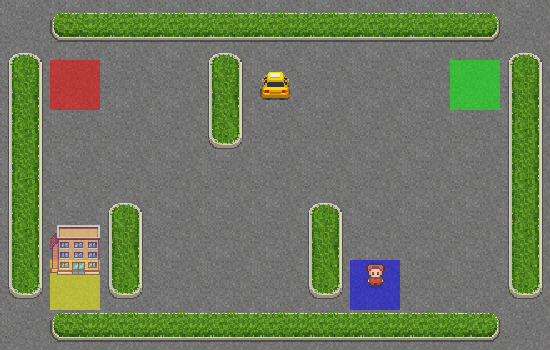

nothing

In [14]:
agent_Q = Agent(:Qlearning);
run_learning!(agent_Q, 100, animated = true)

and after learning:

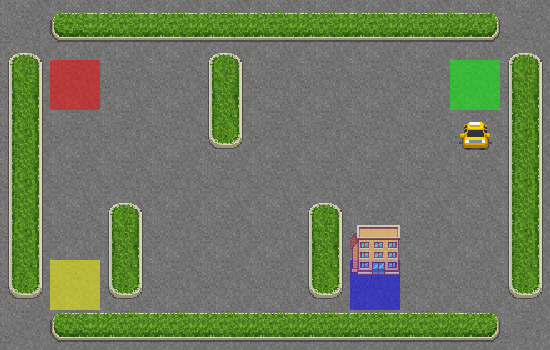

nothing

In [15]:
run_learning!(agent_Q, 250_000)
run_learning!(agent_Q, 200, burning = false, animated = true)

Same for SARSA algorithm:

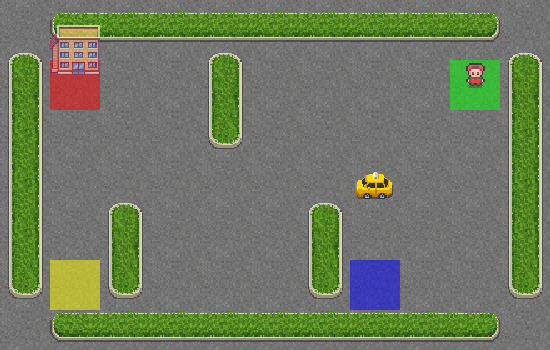

nothing

In [16]:
agent_SARSA = Agent(:SARSA);

run_learning!(agent_SARSA, 100, animated = true)

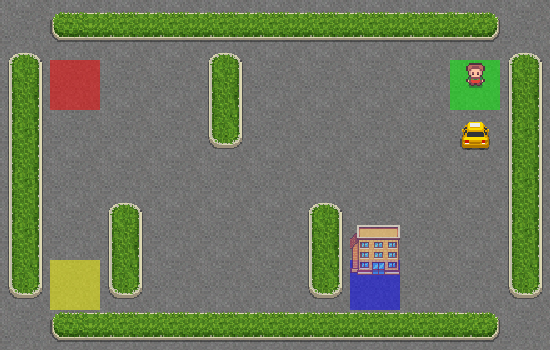

nothing

In [17]:
run_learning!(agent_SARSA, 250_000)
run_learning!(agent_SARSA, 300, burning = false, animated = true)

Plots:

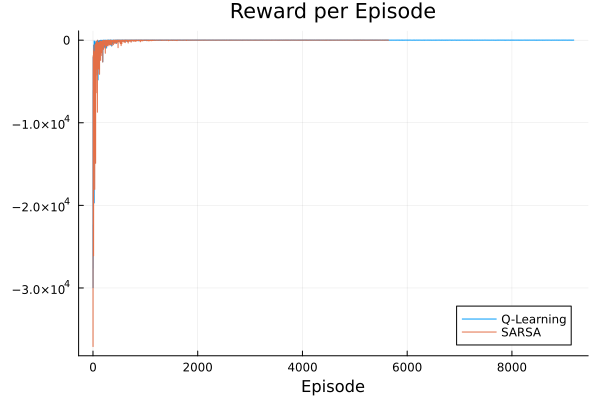

In [18]:
plot(agent_Q.rewards_per_episode,  label = "Q-Learning", title = "Reward per Episode", xlabel = "Episode")
plot!(agent_SARSA.rewards_per_episode,  label = "SARSA")

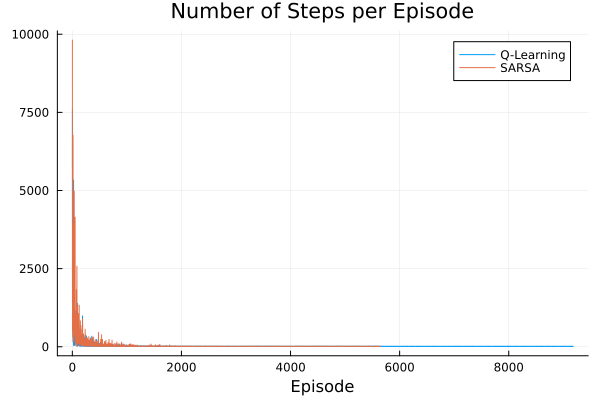

In [19]:
plot(agent_Q.steps_per_episode, label = "Q-Learning", title = "Number of Steps per Episode", xlabel = "Episode")
plot!(agent_SARSA.steps_per_episode, label = "SARSA")
